In [ ]:
# Import libraries
from math import atan2, cos, sin, sqrt, pi
import numpy as np
import cv2 as cv
import os
import glob
import time
from matplotlib.image import imread
import matplotlib.pyplot as plt 
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting plotting parameters
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18) 

In [ ]:
# Load individual Camera Matrices
camera_1400k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_2100K.npz")
K1=camera_1400k['camera_matrix']
D1=camera_1400k['dist_coeffs']

# Load individual Camera Matrices
camera_480k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_480K.npz")
K2=camera_480k['camera_matrix']
D2=camera_480k['dist_coeffs']

# Load the calculated Rotation and Transformation matrices from stereo Calibration
camera_setup=np.load(r"D:\FST_972_FF_Sphere\Calibration\stereo_camera_calibration.npz")
R=camera_setup['rotation_mat']
T=camera_setup['transalation_vect']

## Undistort camera images

### Checking Rectification with Checkerboard Images 

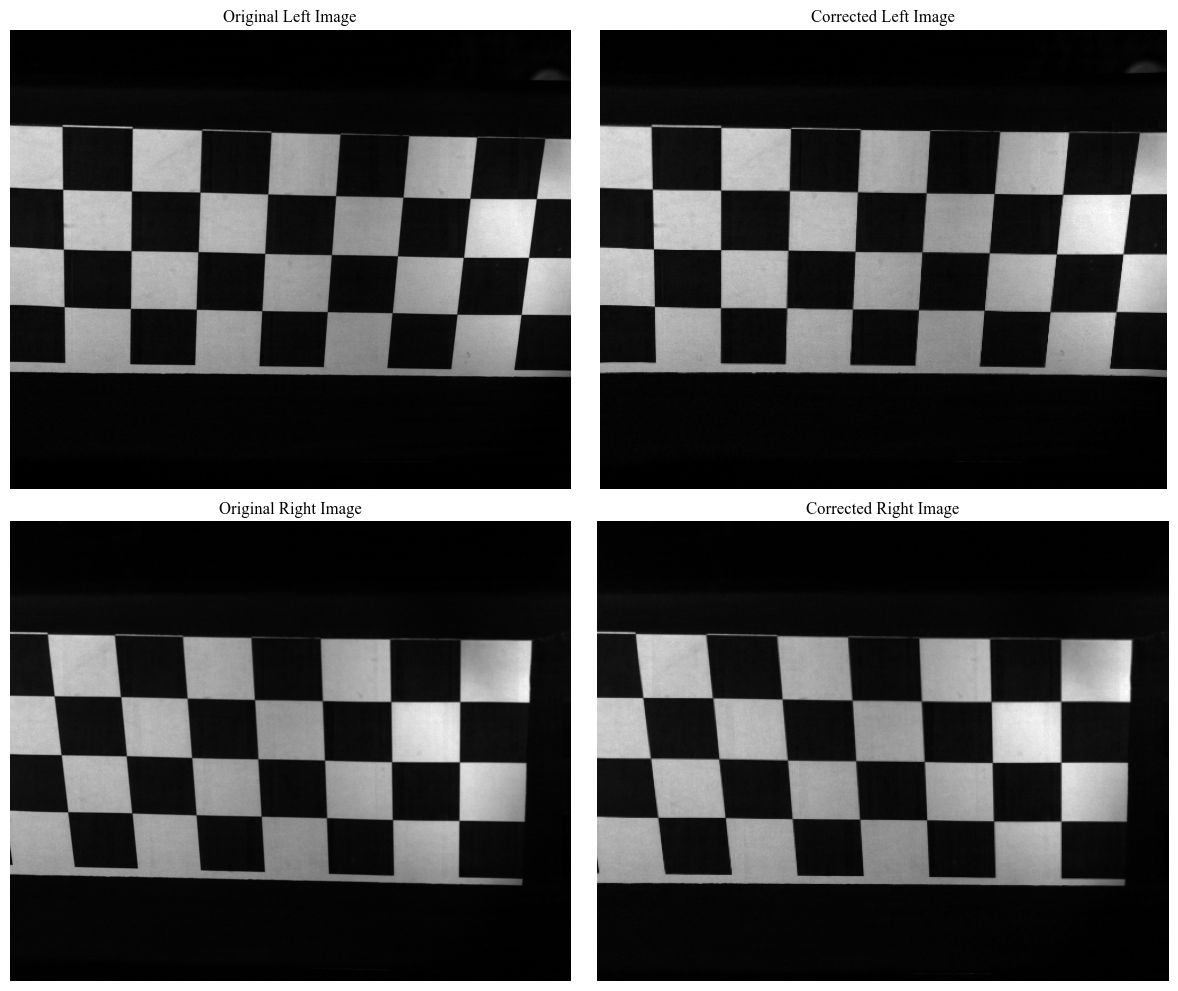

In [ ]:
# Image size (should be the same for both cameras)
image_size = (1024, 840)  # Replace with actual image dimensions

# Stereo rectification
R1, R2, P1, P2, Q, roi1, roi2 = cv.stereoRectify(
    K1, D1, K2, D2, image_size, R, T, 
    flags=cv.CALIB_ZERO_DISPARITY, alpha=1.0
)

# Compute undistortion and rectification transformation maps
map1_x, map1_y = cv.initUndistortRectifyMap(K1, D1, R1, P1, image_size, cv.CV_32FC1)
map2_x, map2_y = cv.initUndistortRectifyMap(K2, D2, R2, P2, image_size, cv.CV_32FC1)

# Camera 1 image
fname1=r"D:\FST_972_FF_Sphere\Calibration\2100K_Checkerboard_FF\Partition 1000150.tif"
image1 = Image.open(fname1)
img1 = np.array(image1)
# Convert 16-bit to 8-bit if needed
if img1.dtype == np.uint16:
    img1 = (img1 / 16).astype(np.uint8)

#Camera 2 image
fname2=r"D:\FST_972_FF_Sphere\Calibration\480K_CheckerBoard_ff_C001H001S0001\480K_CheckerBoard_ff_C001H001S0001000150.tif"
image2 = Image.open(fname2)
img2 = np.array(image2)
# Convert 16-bit to 8-bit if needed
if img2.dtype == np.uint16:
    img2 = (img2 / 16).astype(np.uint8)


# Apply rectification and undistortion
undistorted_rectified_1 = cv.remap(img1, map1_x, map1_y, interpolation=cv.INTER_LINEAR)
undistorted_rectified_2 = cv.remap(img2, map2_x, map2_y, interpolation=cv.INTER_LINEAR)

# Crop images based on ROI (optional)
x, y, w, h = roi1
undistorted_rectified_1 = undistorted_rectified_1[y:y+h, x:x+w]

x, y, w, h = roi2
undistorted_rectified_2 = undistorted_rectified_2[y:y+h, x:x+w]

# Plot the images using Matplotlib
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Left Camera - Original vs. Corrected
axes[0, 0].imshow(img1, cmap='gray')
axes[0, 0].set_title("Original Left Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(undistorted_rectified_1, cmap='gray')
axes[0, 1].set_title("Corrected Left Image")
axes[0, 1].axis("off")

# Right Camera - Original vs. Corrected
axes[1, 0].imshow(img2, cmap='gray')
axes[1, 0].set_title("Original Right Image")
axes[1, 0].axis("off")

axes[1, 1].imshow(undistorted_rectified_2, cmap='gray')
axes[1, 1].set_title("Corrected Right Image")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


### Undistort all Sphere Images from both Cameras

In [255]:
# Load camera calibration parameters
camera_1400k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_2100K.npz")
K1 = camera_1400k['camera_matrix']
D1 = camera_1400k['dist_coeffs']

camera_480k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_480K.npz")
K2 = camera_480k['camera_matrix']
D2 = camera_480k['dist_coeffs']

camera_setup = np.load(r"D:\FST_972_FF_Sphere\Calibration\stereo_camera_calibration.npz")
R = camera_setup['rotation_mat']
T = camera_setup['transalation_vect']


In [256]:
# Image size (should be the same for both cameras)
image_size = (1024, 840)  # Replace with actual image dimensions

# Stereo rectification
R1, R2, P1, P2, Q, roi1, roi2 = cv.stereoRectify(
    K1, D1, K2, D2, image_size, R, T, 
    flags=cv.CALIB_ZERO_DISPARITY, alpha=1.0
)

# Compute undistortion and rectification transformation maps
map1_x, map1_y = cv.initUndistortRectifyMap(K1, D1, R1, P1, image_size, cv.CV_32FC1)
map2_x, map2_y = cv.initUndistortRectifyMap(K2, D2, R2, P2, image_size, cv.CV_32FC1)

In [257]:
# Input folders
input_folder1 = r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Aligned_images"
input_folder2 = r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\Aligned_images"

# Output folders
output_folder1 = r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Undistorted_2100K"
output_folder2 = r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\Undistorted_480K"

# Create output folders if they don't exist
os.makedirs(output_folder1, exist_ok=True)
os.makedirs(output_folder2, exist_ok=True)

# Get list of image files
image_files1 = sorted([f for f in os.listdir(input_folder1) if f.endswith(".tif")])
image_files2 = sorted([f for f in os.listdir(input_folder2) if f.endswith(".tif")])

In [258]:
# Process images from both folders
for img_file1, img_file2 in zip(image_files1, image_files2):
    # Read Camera 1 image
    img_path1 = os.path.join(input_folder1, img_file1)
    image1 = Image.open(img_path1)
    img1 = np.array(image1)

    # Convert 16-bit to 8-bit if needed
    if img1.dtype == np.uint16:
        img1 = (img1 / 16).astype(np.uint8)

    # Read Camera 2 image
    img_path2 = os.path.join(input_folder2, img_file2)
    image2 = Image.open(img_path2)
    img2 = np.array(image2)

    # Convert 16-bit to 8-bit if needed
    if img2.dtype == np.uint16:
        img2 = (img2 / 16).astype(np.uint8)

    # Apply rectification and undistortion
    undistorted_rectified_1 = cv.remap(img1, map1_x, map1_y, interpolation=cv.INTER_LINEAR)
    undistorted_rectified_2 = cv.remap(img2, map2_x, map2_y, interpolation=cv.INTER_LINEAR)

    # # Crop images based on ROI (optional)
    x, y, w, h = roi1
    undistorted_rectified_1 = undistorted_rectified_1[y:y+h, x:x+w]

    x, y, w, h = roi2
    undistorted_rectified_2 = undistorted_rectified_2[y:y+h, x:x+w]

    # Save images in output folders
    out_path1 = os.path.join(output_folder1, img_file1)
    out_path2 = os.path.join(output_folder2, img_file2)

    cv.imwrite(out_path1, undistorted_rectified_1)
    cv.imwrite(out_path2, undistorted_rectified_2)

    print(f"Processed: {img_file1} and {img_file2}")

print("All images processed and saved successfully!")

Processed: Partition 1001201.tif and 480K_FST_972_FF_Run_C001H001S0001001201.tif
Processed: Partition 1001202.tif and 480K_FST_972_FF_Run_C001H001S0001001202.tif
Processed: Partition 1001203.tif and 480K_FST_972_FF_Run_C001H001S0001001203.tif
Processed: Partition 1001204.tif and 480K_FST_972_FF_Run_C001H001S0001001204.tif
Processed: Partition 1001205.tif and 480K_FST_972_FF_Run_C001H001S0001001205.tif
Processed: Partition 1001206.tif and 480K_FST_972_FF_Run_C001H001S0001001206.tif
Processed: Partition 1001207.tif and 480K_FST_972_FF_Run_C001H001S0001001207.tif
Processed: Partition 1001208.tif and 480K_FST_972_FF_Run_C001H001S0001001208.tif
Processed: Partition 1001209.tif and 480K_FST_972_FF_Run_C001H001S0001001209.tif
Processed: Partition 1001210.tif and 480K_FST_972_FF_Run_C001H001S0001001210.tif
Processed: Partition 1001211.tif and 480K_FST_972_FF_Run_C001H001S0001001211.tif
Processed: Partition 1001212.tif and 480K_FST_972_FF_Run_C001H001S0001001212.tif
Processed: Partition 1001213

## Track 2d points in 480K camera

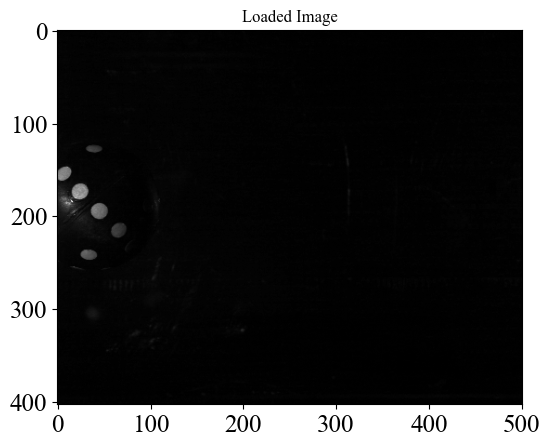

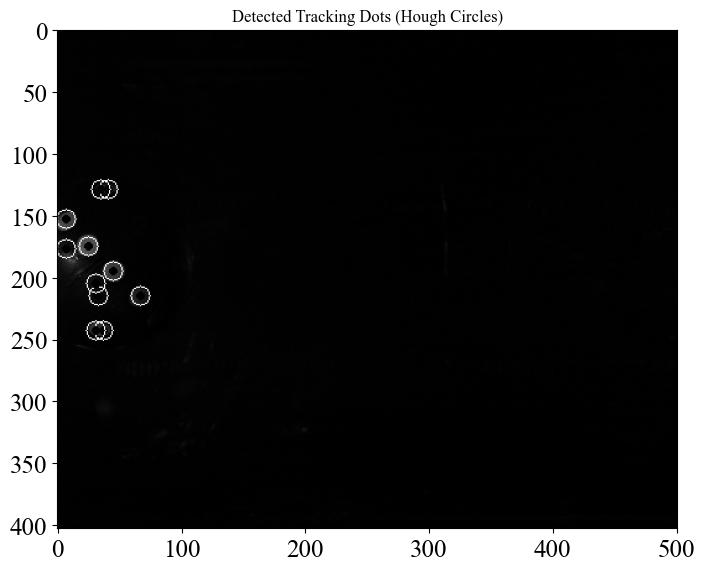

{'dot_0': (33, 215),
 'dot_1': (31, 205),
 'dot_2': (45, 195),
 'dot_3': (67, 215),
 'dot_4': (41, 129),
 'dot_5': (7, 177),
 'dot_6': (25, 175),
 'dot_7': (37, 243),
 'dot_8': (7, 153),
 'dot_9': (31, 243),
 'dot_10': (35, 129)}

In [216]:
# Load the image
file_path = r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\Undistorted_480K\480K_FST_972_FF_Run_C001H001S0001001280.tif"
image = Image.open(file_path)
image_array = np.array(image)

# Convert to 8-bit grayscale if necessary
if image_array.dtype == np.uint16:
    image_array = (image_array / 16).astype(np.uint8)  # Scale from 12-bit/16-bit to 8-bit

# Display the first frame for inspection
plt.figure(figsize=(6, 6))
plt.imshow(image_array, cmap='gray')
plt.title("Loaded Image")
plt.axis("on")
plt.show()

# Preprocessing: Apply adaptive thresholding to enhance contrast
thresh = cv.adaptiveThreshold(image_array, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv.THRESH_BINARY_INV, 11, 2)

# Apply Gaussian Blur to smooth the image
blurred = cv.GaussianBlur(thresh, (5, 5), 0)

# Try Hough Circle Transform for circular dots
circles = cv.HoughCircles(
    blurred, cv.HOUGH_GRADIENT, dp=2, minDist=6,
    param1=45, param2=25, minRadius=5, maxRadius=9
)

output_image = np.copy(image_array)
# Store detected dots
dot_coordinates = {}

# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i, circle in enumerate(circles[0, :]):
        x, y, r = circle
        dot_coordinates[f"dot_{i}"] = (x, y)
        cv.circle(output_image, (x, y), r, (255, 0, 0), 1)  # Draw outer circle
        cv.circle(output_image, (x, y), 2, (0, 255, 0), 2)  # Draw center

# Display the detected dots
plt.figure(figsize=(8, 8))
plt.imshow(output_image, cmap="gray")
plt.title("Detected Tracking Dots (Hough Circles)")
plt.axis("on")
plt.show()

# Output detected dot coordinates
dot_coordinates

In [ ]:
##detected_circle1: 'dot_0': (13, 213) ref=0
##detected_circle2: 'dot_0': (13, 193) ref=30
##detected_circle3: 'dot_3': (13, 173) ref=55
##detected_circle4: 'dot_6': (7, 153)  ref=80
##detected_circle5: 'dot_7': (37, 243) ref=80
#detected_circle6: 'dot_4': (9, 189) ref=130 ## second attempt

In [221]:
# Output folders
# output_folder1 = r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\detected_circle1"
output_folder2 = r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\detected_circle5"

# Create output folders if they don't exist
# os.makedirs(output_folder1, exist_ok=True)
os.makedirs(output_folder2, exist_ok=True)

In [222]:
# Folder containing all images
image_folder = r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\Undistorted_480K"  # Change this to your folder
image_files = sorted(glob.glob(image_folder + r"\*.tif"))  # Read all TIFF images in order

# Manually set the dot you want to track from the first frame
selected_dot = dot_coordinates['dot_7']  # Replace (x, y) with the chosen dot's coordinates from detection

ref = 80 #enter ref frame used for template

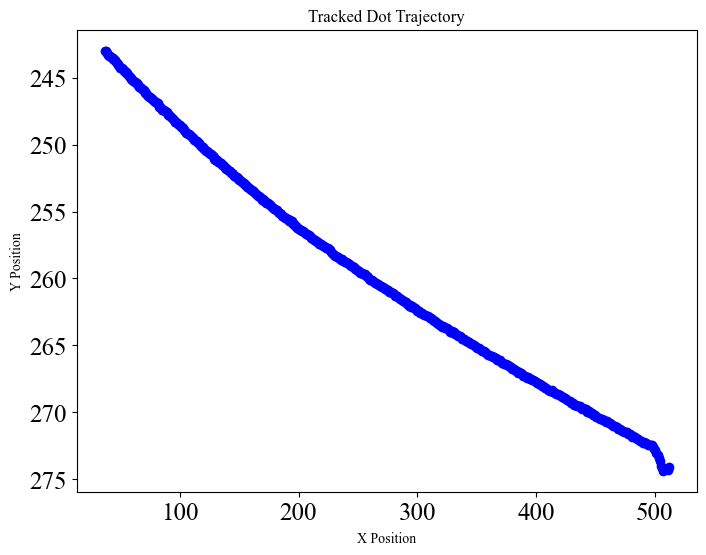

In [223]:
# Read the first frame
first_frame = Image.open(image_files[ref])
first_frame = np.array(first_frame)

# Convert to 8-bit grayscale if necessary
if first_frame.dtype == np.uint16:
    first_frame = (first_frame / 16).astype(np.uint8)

# Convert to grayscale
prev_gray = first_frame

# Convert selected dot into NumPy array for tracking
prev_point = np.array([selected_dot], dtype=np.float32).reshape(-1, 1, 2)

# Store dot trajectory
trajectory = [selected_dot]

# Optical Flow parameters
lk_params = dict(winSize=(25, 25), maxLevel=3,
                 criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# Process subsequent frames
for idx, img_path in enumerate(image_files[ref+1:]):  # Process all other frames
    # Read current frame
    current_frame = Image.open(img_path)
    current_frame = np.array(current_frame)

    # Convert to 8-bit grayscale if necessary
    if current_frame.dtype == np.uint16:
        current_frame = (current_frame / 16).astype(np.uint8)

    # Convert to grayscale
    frame_gray = current_frame

    # Track the selected point using Optical Flow
    new_point, status, _ = cv.calcOpticalFlowPyrLK(prev_gray, frame_gray, prev_point, None, **lk_params)
    # print(status)

    # If tracking is successful, update the point
    if status[0]:
        x, y = new_point.ravel()
        trajectory.append((x, y))
        prev_point = new_point.reshape(-1, 1, 2)

        # Convert grayscale image to BGR for drawing
        frame_bgr = cv.cvtColor(frame_gray, cv.COLOR_GRAY2BGR)

        # Draw the tracked circle
        cv.circle(frame_bgr, (int(x), int(y)), 10, (0, 255, 0), 2)  # Green circle
        cv.circle(frame_bgr, (int(x), int(y)), 2, (0, 0, 255), -1)  # Red center dot

        # Save the image
        output_path = os.path.join(output_folder2, f"tracked_{idx+1:04d}.png")
        cv.imwrite(output_path, frame_bgr)

    # Update previous frame
    prev_gray = frame_gray.copy()

# Plot the tracked trajectory
trajectory = np.array(trajectory)
plt.figure(figsize=(8, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], marker="o", linestyle="-", color="blue")
plt.gca().invert_yaxis()  # Flip to match image coordinates
plt.title("Tracked Dot Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()


In [69]:
trajectory

array([[197.     , 381.     ],
       [197.69281, 381.17813],
       [198.43768, 381.26575],
       ...,
       [637.19104, 456.83148],
       [637.4908 , 456.9084 ],
       [637.7824 , 456.97617]], dtype=float32)

In [224]:
np.save(r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\detected_circle5.npy",trajectory)

## Track 2d points in 2100K camera

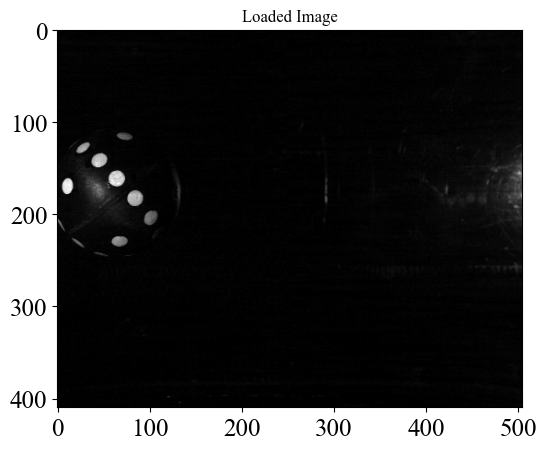

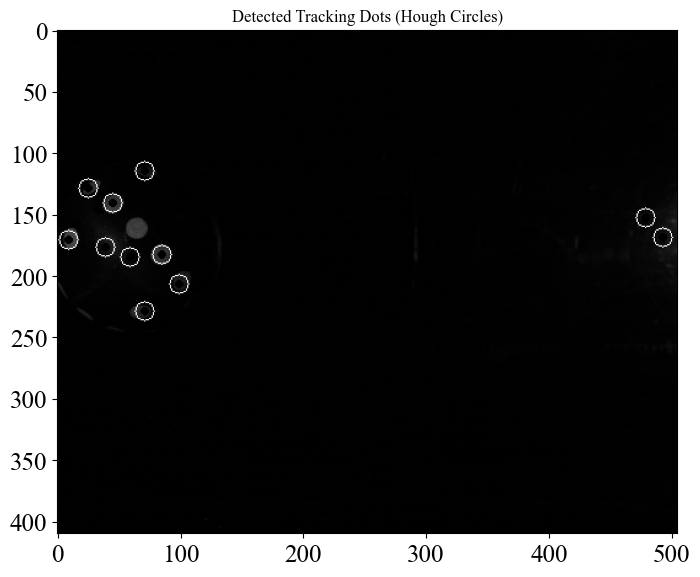

{'dot_0': (85, 183),
 'dot_1': (45, 141),
 'dot_2': (59, 185),
 'dot_3': (71, 115),
 'dot_4': (71, 229),
 'dot_5': (9, 171),
 'dot_6': (25, 129),
 'dot_7': (99, 207),
 'dot_8': (479, 153),
 'dot_9': (39, 177),
 'dot_10': (493, 169)}

In [152]:
# Load the image
file_path = r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Undistorted_2100K\Partition 1001260.tif"
#"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Undistorted_2100K\Partition 1001325.tif"
image = Image.open(file_path)
image_array = np.array(image)

# Convert to 8-bit grayscale if necessary
if image_array.dtype == np.uint16:
    image_array = (image_array / 16).astype(np.uint8)  # Scale from 12-bit/16-bit to 8-bit

# Display the first frame for inspection
plt.figure(figsize=(6, 6))
plt.imshow(image_array, cmap='gray')
plt.title("Loaded Image")
plt.axis("on")
plt.show()

# Preprocessing: Apply adaptive thresholding to enhance contrast
thresh = cv.adaptiveThreshold(image_array, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv.THRESH_BINARY_INV, 11, 2)

# Apply Gaussian Blur to smooth the image
blurred = cv.GaussianBlur(thresh, (5, 5), 0)

# Try Hough Circle Transform for circular dots
circles = cv.HoughCircles(
    blurred, cv.HOUGH_GRADIENT, dp=2, minDist=10,
    param1=40, param2=30, minRadius=3, maxRadius=9
)

output_image = np.copy(image_array)
# Store detected dots
dot_coordinates = {}

# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i, circle in enumerate(circles[0, :]):
        x, y, r = circle
        dot_coordinates[f"dot_{i}"] = (x, y)
        cv.circle(output_image, (x, y), r, (255, 0, 0), 1)  # Draw outer circle
        cv.circle(output_image, (x, y), 2, (0, 255, 0), 2)  # Draw center

# Display the detected dots
plt.figure(figsize=(8, 8))
plt.imshow(output_image, cmap="gray")
plt.title("Detected Tracking Dots (Hough Circles)")
plt.axis("on")
plt.show()

# Output detected dot coordinates
dot_coordinates

In [ ]:
##detected_circle1: 'dot_0': (63, 203) ref=0
##detected_circle2: 'dot_2': (47, 181) ref=0
##detected_circle3: 'dot_1': (29, 157) ref=0
##detected_circle4: 'dot_3': (11, 135) ref=0
##detected_circle5: 'dot_9': (31, 225) ref=0
##detected_circle6: 'dot_5': (9, 171) ref=60


In [153]:
# Output folders
output_folder1 = r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\detected_circle6"
# output_folder2 = r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\detected_circle6"

# Create output folders if they don't exist
os.makedirs(output_folder1, exist_ok=True)
# os.makedirs(output_folder2, exist_ok=True)

In [154]:
# Folder containing all images
image_folder = r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Undistorted_2100K"  # Change this to your folder
image_files = sorted(glob.glob(image_folder + r"\*.tif"))  # Read all TIFF images in order

# Manually set the dot you want to track from the first frame
selected_dot = dot_coordinates['dot_5']  # Replace (x, y) with the chosen dot's coordinates from detection

ref = 60 #enter ref frame used for template

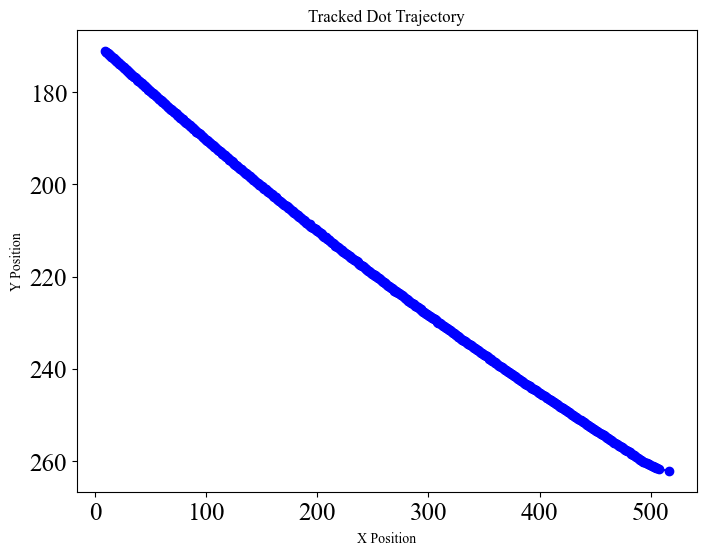

In [155]:
# Read the first frame
first_frame = Image.open(image_files[ref])
first_frame = np.array(first_frame)

# Convert to 8-bit grayscale if necessary
if first_frame.dtype == np.uint16:
    first_frame = (first_frame / 16).astype(np.uint8)

# Convert to grayscale
prev_gray = first_frame

# Convert selected dot into NumPy array for tracking
prev_point = np.array([selected_dot], dtype=np.float32).reshape(-1, 1, 2)

# Store dot trajectory
trajectory = [selected_dot]

# Optical Flow parameters
lk_params = dict(winSize=(25, 25), maxLevel=3,
                 criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# Process subsequent frames
for idx, img_path in enumerate(image_files[ref+1:]):  # Process all other frames
    # Read current frame
    current_frame = Image.open(img_path)
    current_frame = np.array(current_frame)

    # Convert to 8-bit grayscale if necessary
    if current_frame.dtype == np.uint16:
        current_frame = (current_frame / 16).astype(np.uint8)

    # Convert to grayscale
    frame_gray = current_frame

    # Track the selected point using Optical Flow
    new_point, status, _ = cv.calcOpticalFlowPyrLK(prev_gray, frame_gray, prev_point, None, **lk_params)
    # print(status)

    # If tracking is successful, update the point
    if status[0]:
        x, y = new_point.ravel()
        trajectory.append((x, y))
        prev_point = new_point.reshape(-1, 1, 2)

        # Convert grayscale image to BGR for drawing
        frame_bgr = cv.cvtColor(frame_gray, cv.COLOR_GRAY2BGR)

        # Draw the tracked circle
        cv.circle(frame_bgr, (int(x), int(y)), 10, (0, 255, 0), 2)  # Green circle
        cv.circle(frame_bgr, (int(x), int(y)), 2, (0, 0, 255), -1)  # Red center dot

        # Save the image
        output_path = os.path.join(output_folder1, f"tracked_{idx+1:04d}.png")
        cv.imwrite(output_path, frame_bgr)

    # Update previous frame
    prev_gray = frame_gray.copy()

# Plot the tracked trajectory
trajectory = np.array(trajectory)
plt.figure(figsize=(8, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], marker="o", linestyle="-", color="blue")
plt.gca().invert_yaxis()  # Flip to match image coordinates
plt.title("Tracked Dot Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()


In [157]:
np.save(r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\detected_circle6.npy",trajectory)

## Compute 3d points

In [4]:
# === 1. Load Camera Calibration Parameters ===
camera_1400k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_2100K.npz")
K1 = camera_1400k['camera_matrix']
D1 = camera_1400k['dist_coeffs']

camera_480k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_480K.npz")
K2 = camera_480k['camera_matrix']
D2 = camera_480k['dist_coeffs']

camera_setup = np.load(r"D:\FST_972_FF_Sphere\Calibration\stereo_camera_calibration_best.npz")
R = camera_setup['rotation_mat']
T = camera_setup['transalation_vect']

# === 2. Compute Projection Matrices ===
# For camera 1, assume its coordinate system is the reference:
P1 = K1 @ np.hstack((np.eye(3), np.zeros((3, 1))))
# For camera 2, use the rotation and translation from stereo calibration:
P2 = K2 @ np.hstack((R, T.reshape(-1, 1)))


In [ ]:
#2100K
##detected_circle1: 'dot_0': (63, 203) ref=0
##detected_circle2: 'dot_2': (47, 181) ref=0
##detected_circle3: 'dot_1': (29, 157) ref=0
##detected_circle4: 'dot_3': (11, 135) ref=0
##detected_circle5: 'dot_9': (31, 225) ref=0
##detected_circle6: 'dot_5': (9, 171)  ref=60


#480K
##detected_circle1: 'dot_0': (13, 213) ref=0
##detected_circle2: 'dot_0': (13, 193) ref=30
##detected_circle3: 'dot_3': (13, 173) ref=55
##detected_circle4: 'dot_6': (7, 153)  ref=80
##detected_circle5: 'dot_7': (37, 243) ref=80
#detected_circle6: 'dot_4': (9, 189) ref=130 ## second attempt




In [24]:
num = 6

folder_name1 = r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\detected_circle" + str(num)
start_frame1 = 1261

# 1. Get all .tif files in sorted order
image_files1 = sorted(glob.glob(os.path.join(folder_name1, "*.png")))

# 2. Generate a frame number array
#    If the first file corresponds to 'start_frame', then
#    the second file corresponds to 'start_frame + 1', etc.
num_images1 = len(image_files1)
frames_cam1 = np.array([start_frame1 + i for i in range(num_images1)], dtype=int)

folder_name2 = r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\detected_circle" + str(num)
start_frame2 = 1331

# 1. Get all .tif files in sorted order
image_files2 = sorted(glob.glob(os.path.join(folder_name2, "*.png")))

# 2. Generate a frame number array
#    If the first file corresponds to 'start_frame', then
#    the second file corresponds to 'start_frame + 1', etc.
num_images2 = len(image_files2)
frames_cam2 = np.array([start_frame2 + i for i in range(num_images2)], dtype=int)

# print(frames_cam1)
# print(frames_cam2)

# === 3. Load 2D Coordinates for the Same Point from Each Camera ===
# Here we define sample coordinates.
# Replace these with the actual (u, v) coordinates from your tracking.

point_cam1 = np.load(r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\detected_circle"+str(num)+".npy") # from camera 1
point_cam2 = np.load(r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\detected_circle"+str(num)+".npy")# from camera 2

# Build dictionaries for quick lookup
dict_cam1 = {f: (u, v) for f, (u, v) in zip(frames_cam1, point_cam1)}
dict_cam2 = {f: (u, v) for f, (u, v) in zip(frames_cam2, point_cam2)}

# --- STEP 2: Intersect frame numbers and build aligned arrays ---
common_frames = sorted(set(dict_cam1.keys()) & set(dict_cam2.keys()))

aligned_pts_cam1 = []
aligned_pts_cam2 = []
aligned_frames = []

for f in common_frames:
    aligned_pts_cam1.append(dict_cam1[f])  # (u, v) from cam1
    aligned_pts_cam2.append(dict_cam2[f])  # (u, v) from cam2
    aligned_frames.append(f)

# Convert to NumPy arrays of shape (N, 2)
aligned_pts_cam1 = np.array(aligned_pts_cam1, dtype=np.float32)
aligned_pts_cam2 = np.array(aligned_pts_cam2, dtype=np.float32)
aligned_frames = np.array(aligned_frames, dtype=int)

# print("Aligned frames:", aligned_frames)
print("aligned_pts_cam1 shape:", aligned_pts_cam1.shape)
print("aligned_pts_cam2 shape:", aligned_pts_cam2.shape)

np.save(r"D:\FST_972_FF_Sphere\FST_972_Run\point"+str(num)+"_3d_frames_v2.npy", aligned_frames)


aligned_pts_cam1 shape: (551, 2)
aligned_pts_cam2 shape: (551, 2)


In [25]:
# Triangulate all points at once if you want a single array of 3D points:
# We must transpose to shape (2, N) for triangulatePoints.
pts1_T = aligned_pts_cam1.T  # shape (2, N)
pts2_T = aligned_pts_cam2.T  # shape (2, N)

points_4d = cv.triangulatePoints(P1, P2, pts1_T, pts2_T)  # shape (4, N)
points_4d /= points_4d[3]  # normalize
points_3d = points_4d[:3].T  # shape (N, 3)

print("3D points shape:", points_3d.shape)
print("3D points (first few):\n", points_3d[:5])

# === 5. Save the 3D Coordinates ===
np.save(r"D:\FST_972_FF_Sphere\FST_972_Run\point"+str(num)+"_3d_v2.npy", points_3d)

3D points shape: (551, 3)
3D points (first few):
 [[-99.78943  -43.34182  719.21533 ]
 [-99.65067  -43.31744  719.2898  ]
 [-99.55334  -43.294712 719.5089  ]
 [-99.35821  -43.25727  719.3838  ]
 [-99.26996  -43.230835 719.5873  ]]


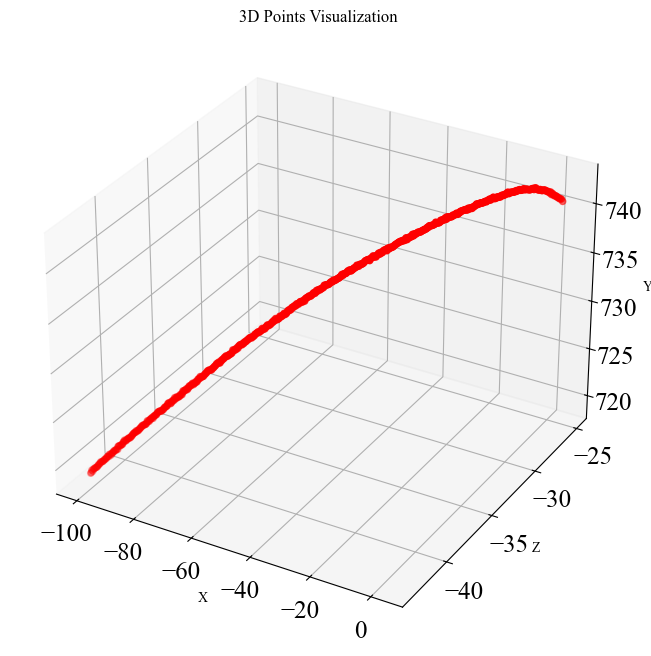

In [26]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points (you can adjust color, marker, etc.)
ax.scatter(points_3d[:,0 ], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')

# Label axes
ax.set_title("3D Points Visualization")
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y")

plt.show()

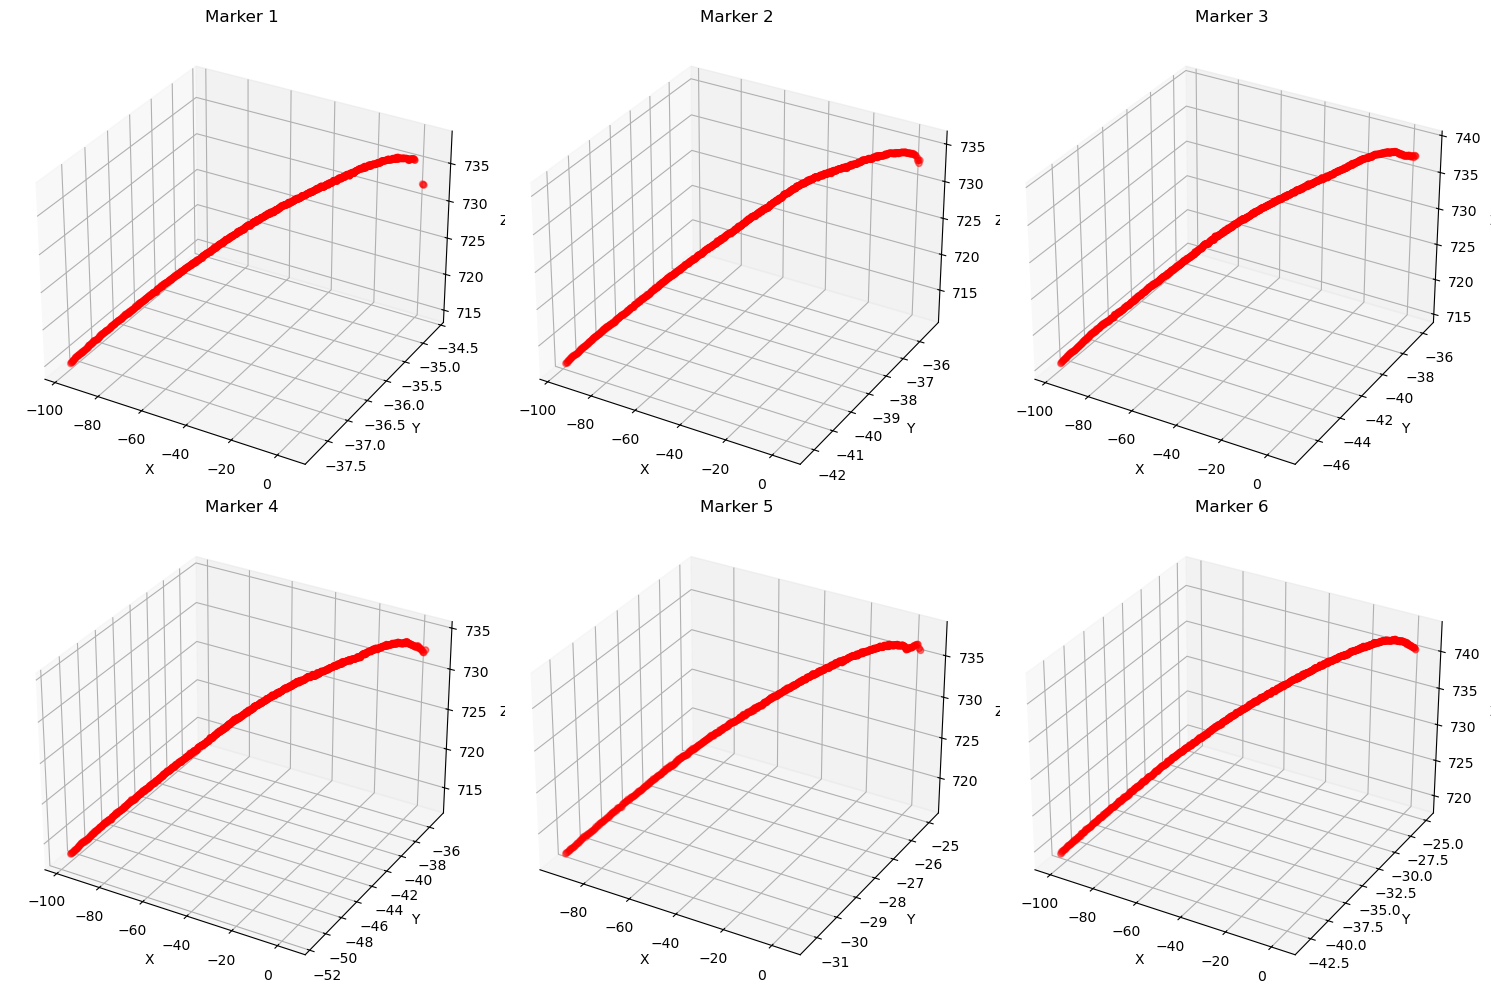

In [ ]:

# List of file paths for the six markers (update these paths to your actual files)
files = [
    r"D:\FST_972_FF_Sphere\FST_972_Run\point1_3d_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point2_3d_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point3_3d_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point4_3d_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point5_3d_v2.npy",
    r"D:\FST_972_FF_Sphere\FST_972_Run\point6_3d_v2.npy"
]

# Create a figure with 6 subplots (2 rows x 3 columns)
fig = plt.figure(figsize=(15, 10))

for i, file in enumerate(files):
    # Load the 3D points for marker i
    points_3d = np.load(file)  # Expected shape: (num_frames, 3)
    
    # Create a 3D subplot in position i+1
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    
    # Scatter plot the 3D points
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
               c='r', marker='o')
    
    # Set labels and title for the subplot
    ax.set_title(f"Marker {i+1}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

plt.tight_layout()
plt.show()
